In [1]:
import pandas as pd
df = pd.read_csv(r'C:\Users\baraju\Cluster-AMF\Input_Data.csv')
df['N2_s1mme_total'] = df['N2_total'] + df['s1mme_total']
df['N11_s11_total'] = df['N11_total'] + df['s11_total']
df['N12_s6ad_total'] = df['N12_total'] + df['s6ad_total']
df['PCMD_total'] = df['NT_AMF_PCMD'] + df['NT_SGSN_PCMD'] + df['NT_MME_PCMD']

df.head(2)

,Timestamp,Node Name,Date,Time,Day of the week,emmState_registered_subscriber_count,emmState_deregistered_subscriber_count,ecmState_connected_subscriber_count,ecmState_idle_subscriber_count,amfRmState_registered_subscriber_count,...,sgs_enabled,sgs_disabled,sgs_total,NT_AMF_PCMD,NT_SGSN_PCMD,NT_MME_PCMD,N2_s1mme_total,N11_s11_total,N12_s6ad_total,PCMD_total
0,15-04-2024 13:14,AMF-INFRA,15-04-2024,13:14:28,Monday,0,0,0,0,1,...,0,0,0,7,0,0,34,1,2,7
1,15-04-2024 13:14,AMF-SLAB-BLR,15-04-2024,13:14:28,Monday,0,0,0,0,4,...,0,0,0,0,0,0,18,2,2,0


In [2]:
df.columns.to_list()

['Timestamp',
 'Node Name',
 'Date',
 'Time',
 'Day of the week',
 'emmState_registered_subscriber_count',
 'emmState_deregistered_subscriber_count',
 'ecmState_connected_subscriber_count',
 'ecmState_idle_subscriber_count',
 'amfRmState_registered_subscriber_count',
 'amfRmState_deregistered_subscriber_count',
 'amfCmState_connected_subscriber_count',
 'amfCmState_idle_subscriber_count',
 'subscriber_count',
 'N2_enabled',
 'N2_disabled',
 'N2_total',
 'N12_enabled',
 'N12_disabled',
 'N12_total',
 'N8_enabled',
 'N8_disabled',
 'N8_total',
 'N11_enabled',
 'N11_disabled',
 'N11_total',
 'N15_enabled',
 'N15_disabled',
 'N15_total',
 's1mme_enabled',
 's1mme_disabled',
 's1mme_total',
 's6ad_enabled',
 's6ad_disabled',
 's6ad_total',
 's11_enabled',
 's11_disabled',
 's11_total',
 'sgs_enabled',
 'sgs_disabled',
 'sgs_total',
 'NT_AMF_PCMD',
 'NT_SGSN_PCMD',
 'NT_MME_PCMD',
 'N2_s1mme_total',
 'N11_s11_total',
 'N12_s6ad_total',
 'PCMD_total']

In [3]:
Need_columns = [ 'Node Name',
 'subscriber_count',
 'N2_s1mme_total',               
 'PCMD_total']

df = df[Need_columns]

df.head()

,Node Name,subscriber_count,N2_s1mme_total,PCMD_total
0,AMF-INFRA,1,34,7
1,AMF-SLAB-BLR,7,18,0
2,AMF-GUMPERT-SRN-BLR,0,3,0
3,TC4-CMM-BILLA-SRN-BLR,105,291,2731
4,cMM_AMF-Blackbird-SRN-BLR,0,3,0


In [4]:
cl_data = df.drop(['Node Name'], axis=1)

In [5]:
# Handle outliers using RobustScaler

from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(cl_data)

In [6]:
# Dimensionality reduction with t-SNE
from sklearn.manifold import TSNE, SpectralEmbedding

tsne = TSNE(n_components=2, random_state=0)
tsne_components = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])

In [7]:
import numpy as np
#import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
#from sklearn.metrics import silhouette_score

In [8]:
# Initialize clustering algorithms
clustering_algorithms = [
    ("KMeans", KMeans(n_clusters=6)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=6)),
    ("Spectral", SpectralClustering(n_clusters=6)),
    ("Birch", Birch(n_clusters=6)),
    ("GMM", GaussianMixture(n_components=6))
]

# Perform clustering and append results to DataFrame
for name, algorithm in clustering_algorithms:
    algorithm.fit(tsne_df)
    if hasattr(algorithm, 'labels_'):
        df[name] = algorithm.labels_
    else:
        # For GMM, assign labels based on highest probability
        probabilities = algorithm.predict_proba(tsne_df)
        labels = np.argmax(probabilities, axis=1)
        df[name] = labels
    


C:\Users\baraju\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [9]:
labels = ["Blocker", "Critical", "Major", "Major", "Major", "Trivial"]

# KMeans Lable Mapping

cluster_means = df.groupby('KMeans')['PCMD_total'].mean()
cluster_means_int = cluster_means.astype(int)
cluster_means_int_sorted = cluster_means_int.sort_values(ascending=False)

cluster_df = pd.DataFrame({'KMeans': cluster_means_int_sorted.index,})
cluster_df['Label'] = labels

cluster_label_map = dict(zip(cluster_df['KMeans'], cluster_df['Label']))
df['KMeans_T'] = df['KMeans'].map(cluster_label_map)

# Agglomerative Lable Mapping

cluster_means = df.groupby('Agglomerative')['PCMD_total'].mean()
cluster_means_int = cluster_means.astype(int)
cluster_means_int_sorted = cluster_means_int.sort_values(ascending=False)

cluster_df = pd.DataFrame({'Agglomerative': cluster_means_int_sorted.index,})
cluster_df['Label'] = labels

cluster_label_map = dict(zip(cluster_df['Agglomerative'], cluster_df['Label']))
df['Agglomerative_T'] = df['Agglomerative'].map(cluster_label_map)

# Spectral Lable Mapping

cluster_means = df.groupby('Spectral')['PCMD_total'].mean()
cluster_means_int = cluster_means.astype(int)
cluster_means_int_sorted = cluster_means_int.sort_values(ascending=False)

cluster_df = pd.DataFrame({'Spectral': cluster_means_int_sorted.index,})
cluster_df['Label'] = labels

cluster_label_map = dict(zip(cluster_df['Spectral'], cluster_df['Label']))
df['Spectral_T'] = df['Spectral'].map(cluster_label_map)

# Birch Lable Mapping

cluster_means = df.groupby('Birch')['PCMD_total'].mean()
cluster_means_int = cluster_means.astype(int)
cluster_means_int_sorted = cluster_means_int.sort_values(ascending=False)

cluster_df = pd.DataFrame({'Birch': cluster_means_int_sorted.index,})
cluster_df['Label'] = labels

cluster_label_map = dict(zip(cluster_df['Birch'], cluster_df['Label']))
df['Birch_T'] = df['Birch'].map(cluster_label_map)

# GMM Lable Mapping

cluster_means = df.groupby('GMM')['PCMD_total'].mean()
cluster_means_int = cluster_means.astype(int)
cluster_means_int_sorted = cluster_means_int.sort_values(ascending=False)

cluster_df = pd.DataFrame({'GMM': cluster_means_int_sorted.index,})
cluster_df['Label'] = labels

cluster_label_map = dict(zip(cluster_df['GMM'], cluster_df['Label']))
df['GMM_T'] = df['GMM'].map(cluster_label_map)



In [10]:
columns_to_consider = ['KMeans_T', 'Agglomerative_T', 'Spectral_T', 'Birch_T', 'GMM_T']
resultant_column = df[columns_to_consider].mode(axis=1)[0]
df['resultant_column'] = resultant_column

In [11]:
# Save DataFrame to CSV

df.to_csv(r'C:\Users\baraju\Cluster-AMF\clustering_results.csv', index=True)
 
print("Results saved to clustering_results.csv")

Results saved to clustering_results.csv


In [12]:
plot_df = tsne_df
plot_df['resultant_column'] = df['KMeans_T']
plot_df

,TSNE1,TSNE2,resultant_column
0,22.321085,20.980274,Major
1,-27.399784,-45.874844,Major
2,45.292305,-7.594443,Major
3,-90.903229,-84.920517,Critical
4,55.797283,89.745010,Trivial
5,-31.419058,43.712444,Major
6,-83.640266,0.231233,Major
7,7.266414,-49.707005,Blocker
8,-112.073181,-40.624798,Major
9,78.301758,-25.410332,Major


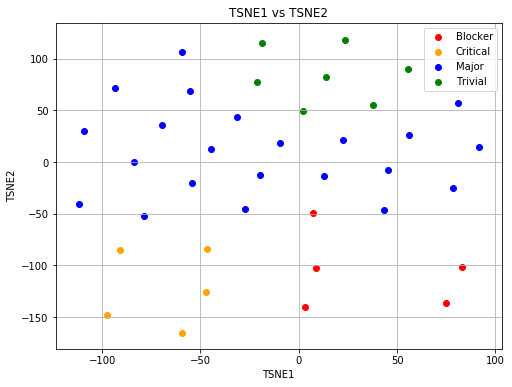

In [13]:
import matplotlib.pyplot as plt

# Separate data points based on 'resultant_column' values
blocker_df = plot_df[plot_df['resultant_column'] == 'Blocker']
critical_df = plot_df[plot_df['resultant_column'] == 'Critical']
major_df = plot_df[plot_df['resultant_column'] == 'Major']
trivial_df = plot_df[plot_df['resultant_column'] == 'Trivial']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(blocker_df['TSNE1'], blocker_df['TSNE2'], color='red', label='Blocker')
plt.scatter(critical_df['TSNE1'], critical_df['TSNE2'], color='orange', label='Critical')
plt.scatter(major_df['TSNE1'], major_df['TSNE2'], color='blue', label='Major')
plt.scatter(trivial_df['TSNE1'], trivial_df['TSNE2'], color='green', label='Trivial')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE1 vs TSNE2')
plt.legend()
plt.grid(True)
plt.show()

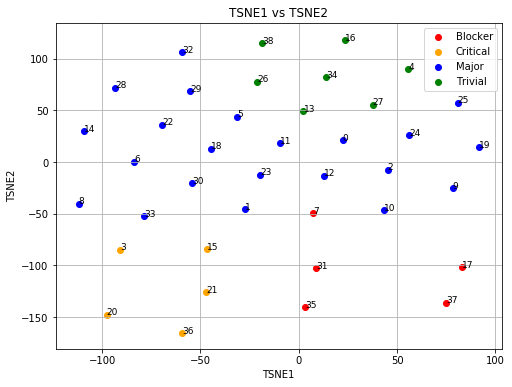

In [14]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(blocker_df['TSNE1'], blocker_df['TSNE2'], color='red', label='Blocker')
plt.scatter(critical_df['TSNE1'], critical_df['TSNE2'], color='orange', label='Critical')
plt.scatter(major_df['TSNE1'], major_df['TSNE2'], color='blue', label='Major')
plt.scatter(trivial_df['TSNE1'], trivial_df['TSNE2'], color='green', label='Trivial')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE1 vs TSNE2')
plt.legend()

# Adding text labels
for index, row in plot_df.iterrows():
    plt.text(row['TSNE1'], row['TSNE2'], str(index), fontsize=9)

plt.grid(True)
plt.show()